## 基于Python 实现 TF-IDF

TF-IDF = TF * IDF

TF = 某个词在一条样本中出现的概率， IDF = log(文本总条数/ 包含该词的文本数) 防止分母为0，一般会对IDF 进行平滑

In [3]:
corpus = ['this is the first document',
              'this is the second second sentence',
              'and the third one',
              'is this the first document']

In [20]:
from collections import Counter
import math
def myTfIdf(corpus):
    """
    :param corpus: 语料
    :return:
    """
    # 第一步完成分词, word_list 中每一个元素都是一条样本
    word_list = []
    for i in range(len(corpus)):
        word_list.append(corpus[i].split())

    
    # 统计词频字典，每一条文本一个，统计的都是词个数
    countlist = []
    for i in range(len(word_list)):
        count = Counter(word_list[i])
        countlist.append(count)

    
    # word 可以通过count 得到，count 可以通过countlist 得到
    # count[word]可以得到每个单词的词频， sum(count.values())得到整个句子的单词总数
    def tf(word, count):
        return count[word] / sum(count.values())
    
    # 统计包含改词的句子数量
    def n_containing(word, word_list):
        return sum([1 for elem in word_list if word in elem])
    
    # 传入 word_list , count_list 都一样
    def idf(word, count_list):
        return math.log(len(count_list) / (1 + n_containing(word, count_list))) # 分母做一个加一平滑
    
    def tfidf(word, count, count_list):
        """
        :param word: 一个单词
        :param count : 一条文本，词频计数字典
        :param count_list: 全部样本的 计数字典组成的列表
        """
        return tf(word, count) * idf(word, count_list)
    
    # 计算每一条样本中每一个词的tfidf 值
    for i, count in enumerate(countlist):
        scores = {word:tfidf(word, count, countlist) for word in count}
        sorted_words = sorted(scores.items(), key=lambda x:x[1], reverse=True)
        for word, score in sorted_words[:]:
            print('\t Word：{}, TFIDF：{}'.format(word, round(score, 5)))
        print('============================================')

In [21]:
myTfIdf(corpus)

	 Word：first, TFIDF：0.05754
	 Word：document, TFIDF：0.05754
	 Word：this, TFIDF：0.0
	 Word：is, TFIDF：0.0
	 Word：the, TFIDF：-0.04463
	 Word：second, TFIDF：0.23105
	 Word：sentence, TFIDF：0.11552
	 Word：this, TFIDF：0.0
	 Word：is, TFIDF：0.0
	 Word：the, TFIDF：-0.03719
	 Word：and, TFIDF：0.17329
	 Word：third, TFIDF：0.17329
	 Word：one, TFIDF：0.17329
	 Word：the, TFIDF：-0.05579
	 Word：first, TFIDF：0.05754
	 Word：document, TFIDF：0.05754
	 Word：is, TFIDF：0.0
	 Word：this, TFIDF：0.0
	 Word：the, TFIDF：-0.04463


### 2、gensim 训练一个 tfidf_vec

gensim 训练出来的tfidf 模型具有自动去除停用词功能，同时还会自动去除单个字母，同时还会去除掉训练集中没有出现的单词

自动去除一些词的特点，导致gensim训练出来的tfidf 模型，不包含所有词的tfidf标识

In [22]:
# 导入gensim中的字典和模型工具包
from gensim.corpora import Dictionary
from gensim import models
import os
"""
第一步: 完成语句的分词.
第二步: 构造映射字典.
第三步: 训练得到TF-IDF模型.
第四步: 加载模型完成文本向量化.
"""

# 一段模拟性的输入文本数据
corpus = ['this is the first document',
          'this is the second second sentence',
          'and the third one',
          'is this the first document']

# 第一步: 完成语句的分词. 手动分词构造列表
word_list = []
for i in range(len(corpus)):
    word_list.append(corpus[i].split())

# print(word_list)
# print('***************************************************')

# 讲分词后的列表结构送入到字典类中，得到实例化对象
# 本质作用是给语料库中的每个单词赋值一个整数id(不重复的词)
# 第二步：构造映射字典.
dictionary = Dictionary(word_list)

# 调用.doc2bow()方法即可得到文本的字典映射
# 结果元组中的第一个元素是单词在词典中对应的id, 第二个元素是单词在文档中的出现次数
new_corpus = [dictionary.doc2bow(text) for text in word_list]
# print(new_corpus)

In [23]:
print(new_corpus)

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1)], [(2, 1), (3, 1), (4, 1), (5, 2), (6, 1)], [(3, 1), (7, 1), (8, 1), (9, 1)], [(0, 1), (1, 1), (2, 1), (3, 1), (4, 1)]]


In [24]:
if not os.path.exists('demo.tfidf'):
    # 打印单词到树枝的映射字典
    print(dictionary.token2id)

    # 将由字典Dictionary 生成的数字化文档new_corpus 作为参数，传入到模型类中训练TF-IDF
    # 第三步: 训练得到TF-IDF模型.
    tfidf = models.TfidfModel(new_corpus)

    # 保存训练好的模型并打印
    tfidf.save('demo.tfidf')
    print(tfidf)
else:
    # 已经训练好demo_tfidf加载进来
    model = models.TfidfModel.load("demo.tfidf")

In [27]:
# 将原始文本，按照训练好的TF-IDF模型进行数字化映射
# 第四步: 加载模型完成文本向量化.
tfidf_vec = []
for i in range(len(corpus)):
    s = corpus[i]
    s_bow = dictionary.doc2bow(s.lower().split()) # [(0, 1), (1, 1), (2, 1), (3, 1), (4, 1)]
    s_tfidf = model[s_bow] # [(0, 0.6530910718344777), (1, 0.6530910718344777), (2, 0.2710572852555213), (4, 0.2710572852555213)]
    tfidf_vec.append(s_tfidf)

In [ ]:
tfidf_vec

[[(0, 0.6530910718344777),
  (1, 0.6530910718344777),
  (2, 0.2710572852555213),
  (4, 0.2710572852555213)],
 [(2, 0.09201607335859055),
  (4, 0.09201607335859055),
  (5, 0.8868217789329863),
  (6, 0.44341088946649315)],
 [(7, 0.5773502691896258), (8, 0.5773502691896258), (9, 0.5773502691896258)],
 [(0, 0.6530910718344777),
  (1, 0.6530910718344777),
  (2, 0.2710572852555213),
  (4, 0.2710572852555213)]]

## BM25 是TF-IDF 的升级

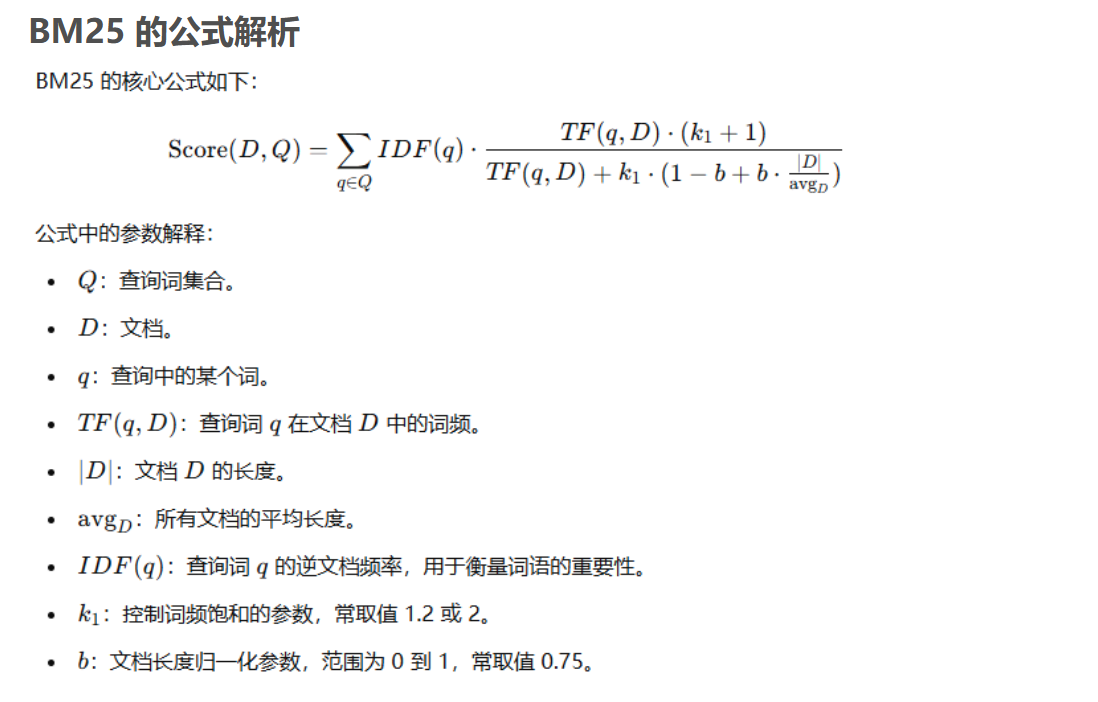

In [45]:
import math
import jieba
import numpy as np
import logging
import pandas as pd
from collections import Counter
jieba.setLogLevel(logging.INFO)

# 测试文本
text = '''
自然语言处理是计算机科学领域与人工智能领域中的一个重要方向。它研究能实现人与计算机之间用自然语言进行有效通信的各种理论和方法。
自然语言处理是一门融语言学、计算机科学、数学于一体的科学。因此，这一领域的研究将涉及自然语言，即人们日常使用的语言，所以它与语言学的研究有着密切的联系，但又有重要的区别。
自然语言处理并不是一般地研究自然语言，而在于研制能有效地实现自然语言通信的计算机系统，特别是其中的软件系统。因而它是计算机科学的一部分。
'''

class BM25(object):
  def __init__(self,docs):
    self.docs = docs   # 传入的docs要求是已经分好词的list 
    self.doc_num = len(docs) # 文档数
    self.vocab = set([word for doc in self.docs for word in doc]) # 文档中所包含的所有词语
    self.avgdl = sum([len(doc) + 0.0 for doc in docs]) / self.doc_num # 所有文档的平均长度
    self.k1 = 1.5
    self.b = 0.75

  def idf(self,word):
    if word not in self.vocab:
      word_idf = 0
    else:
      qn = {}
      for doc in self.docs:
        if word in doc:
          if word in qn:
            qn[word] += 1
          else:
            qn[word] = 1
        else:
          continue
      word_idf = np.log((self.doc_num - qn[word] + 0.5) / (qn[word] + 0.5))
    return word_idf

  def score(self,word):
    """
    计算某一个词word，在不同文档中的公式的后面一串值，文档有几条（数据条数），返回列表的中包含几个元素（都是数值）
    """
    score_list = []
    for index,doc in enumerate(self.docs):
      word_count = Counter(doc)
      if word in word_count.keys():
        f = (word_count[word]+0.0) / len(doc)
      else:
        f = 0.0
      r_score = (f*(self.k1+1)) / (f+self.k1*(1-self.b+self.b*len(doc)/self.avgdl))
      score_list.append(self.idf(word) * r_score)
    # print(score_list)
    return score_list 

  def score_all(self,sequence):
    sum_score = []
    for word in sequence:
      sum_score.append(self.score(word))
    # print(sum_score) # 二位列表，该条查询有几个词，就有几个小列表，每个小列表元素个数就是文档总数
    sim = np.sum(sum_score,axis=0) 
    return sim


In [46]:

stopwords = []
doc_list = [doc for doc in text.split('\n') if doc != '']
docs = []
for sentence in doc_list:
  sentence_words = jieba.lcut(sentence)
  tokens = []
  for word in sentence_words:
    if word in stopwords:
       continue
    else:
      tokens.append(word)
  docs.append(tokens)
print(docs)
  # reutrn 
	# bm = BM25(docs)

	# score = bm.score_all(['自然语言', '计算机科学', '领域', '人工智能', '领域'])

	# print(score)


[['自然语言', '处理', '是', '计算机科学', '领域', '与', '人工智能', '领域', '中', '的', '一个', '重要', '方向', '。', '它', '研究', '能', '实现', '人', '与', '计算机', '之间', '用', '自然语言', '进行', '有效', '通信', '的', '各种', '理论', '和', '方法', '。'], ['自然语言', '处理', '是', '一门', '融', '语言学', '、', '计算机科学', '、', '数学', '于', '一体', '的', '科学', '。', '因此', '，', '这一', '领域', '的', '研究', '将', '涉及', '自然语言', '，', '即', '人们', '日常', '使用', '的', '语言', '，', '所以', '它', '与', '语言学', '的', '研究', '有着', '密切', '的', '联系', '，', '但', '又', '有', '重要', '的', '区别', '。'], ['自然语言', '处理', '并', '不是', '一般', '地', '研究', '自然语言', '，', '而', '在于', '研制', '能', '有效', '地', '实现', '自然语言', '通信', '的', '计算机系统', '，', '特别', '是', '其中', '的', '软件系统', '。', '因而', '它', '是', '计算机科学', '的', '一部分', '。']]


In [47]:
bm = BM25(docs)
score = bm.score_all(['自然语言', '计算机科学', '领域', '人工智能', '领域'])

In [48]:
score = bm.score_all(['自然语言', '计算机科学', '领域', '人工智能', '领域'])

In [ ]:
score
# 输入与第二句的相关性最高

array([-0.4041547 , -0.1855289 , -0.40055461])